In [1]:
DATA_DIR = "./data"
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [2]:
!mkdir -p $DATA_DIR
!test ! -d $DATA_DIR/train \
    && wget -O $DATA_DIR/train.tar https://people.eecs.berkeley.edu/~hendrycks/streethazards_train.tar \
    && tar -xf $DATA_DIR/train.tar -C $DATA_DIR \
    && rm -r $DATA_DIR/train.tar \
    && mv $DATA_DIR/train $DATA_DIR/streethazards_train
!test ! -d $DATA_DIR/test \
    && wget -O $DATA_DIR/test.tar https://people.eecs.berkeley.edu/~hendrycks/streethazards_test.tar \
    && tar -xf $DATA_DIR/test.tar -C $DATA_DIR \
    && rm -r $DATA_DIR/test.tar\
    && mv $DATA_DIR/test $DATA_DIR/streethazards_test

--2025-10-21 22:48:31--  https://people.eecs.berkeley.edu/~hendrycks/streethazards_train.tar
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9386226176 (8.7G) [application/x-tar]
Saving to: ‘./data/train.tar’

./data/train.tar    100%[===================>]   8.74G  13.5MB/s    in 7m 29s  

2025-10-21 22:56:01 (19.9 MB/s) - ‘./data/train.tar’ saved [9386226176/9386226176]

--2025-10-21 22:56:21--  https://people.eecs.berkeley.edu/~hendrycks/streethazards_test.tar
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2150484992 (2.0G) [application/x-tar]
Saving to: ‘./data/test.tar’

./data/test.tar     100%[==================

In [3]:
!pip install -U segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 950.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [4]:
import numpy as np
import os
from enum import IntEnum
import torch
from torch import Tensor
import torch.nn as nn
import segmentation_models_pytorch as smp
from typing import Optional, Callable, Union, Tuple, Dict, List
import json
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms
from torchvision.transforms import v2
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from scipy.ndimage import label
import ipywidgets as widgets
from IPython.display import display
import threading

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
known_classes = 13

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

cuda


In [5]:
class KaggleInteractiveLabeler:
    def __init__(self, image_array, anomaly_map, threshold, on_done_callback=None):
        self.image = image_array
        self.anomaly_map = anomaly_map
        self.threshold = threshold
        self.on_done_callback = on_done_callback
        
        self.annotations = {}
        self.current_class_name = None
        self.is_labeling_active = False
        
        self.ood_mask = self.anomaly_map >= self.threshold
        self.labeled_regions, _ = label(self.ood_mask)
        
        # 1. Crea i widget di controllo
        self.setup_controls()
        
        # 2. Crea la figura matplotlib (verrà visualizzata automaticamente)
        self.fig, self.ax = plt.subplots(figsize=(10, 7))
        self.fig.canvas.header_visible = False
        self.fig.canvas.mpl_connect('button_press_event', self.on_click)
        
        print("Interfaccia pronta. Etichetta gli oggetti e clicca 'Fine e Procedi'.")
        
    def display_all(self):
        """Visualizza i controlli e la figura."""
        # Visualizza prima i controlli
        display(self.controls)
        # Il grafico verrà visualizzato automaticamente sotto i controlli
        self.update_display()

    def setup_controls(self):
        """Crea solo i widget di controllo ipywidgets."""
        self.text_input = widgets.Text(description='Classe:')
        self.button_start = widgets.Button(description="Inizia/Cambia Classe")
        self.button_done = widgets.Button(description="Fine e Procedi", button_style='success')
        self.status_label = widgets.Label(value="Stato: In attesa.")

        self.button_start.on_click(self.on_start_button)
        self.button_done.on_click(self.on_done_button)
        
        self.controls = widgets.VBox([
            widgets.HBox([self.text_input, self.button_start, self.button_done]),
            self.status_label
        ])

    def on_done_button(self, b):
        """Callback per il bottone 'Fine'. Chiude tutto e chiama il callback finale."""
        # Chiudi la figura per rimuoverla dall'output
        plt.close(self.fig)
        # Nascondi i controlli
        self.controls.layout.display = 'none'
        
        # Pulisci l'output della cella per un'esperienza pulita
        clear_output(wait=True) 
        
        if self.on_done_callback:
            self.on_done_callback(self.annotations)

    # Il resto dei metodi rimane invariato
    def update_display(self, message=None):
        self.ax.clear()
        self.ax.imshow(self.image)
        self.ax.imshow(self.anomaly_map, cmap='hot', alpha=0.5 * self.ood_mask)
        if self.annotations:
            combined_mask = np.zeros_like(self.labeled_regions, dtype=float)
            for i, mask in enumerate(self.annotations.values()):
                combined_mask[mask > 0] = i + 1
            self.ax.imshow(combined_mask, cmap='nipy_spectral', alpha=0.6)
        self.ax.set_title("Clicca sulle aree anomale per etichettarle")
        self.ax.axis('off')
        if message: self.status_label.value = message
        self.fig.canvas.draw_idle()

    def on_start_button(self, b):
        class_name = self.text_input.value.strip()
        if not class_name:
            self.update_display("Stato: Errore - Inserisci un nome valido.")
            return
        self.current_class_name = class_name
        self.is_labeling_active = True
        if self.current_class_name not in self.annotations:
            self.annotations[self.current_class_name] = np.zeros_like(self.image[:,:,0], dtype=np.uint8)
        self.update_display(f"Stato: Etichettatura attiva per '{self.current_class_name}'.")

    def on_click(self, event):
        if not self.is_labeling_active or not event.inaxes or not event.xdata: return
        x, y = int(event.xdata), int(event.ydata)
        region_id = self.labeled_regions[y, x]
        if region_id == 0:
            self.update_display(f"Stato: Click fuori area anomala.")
            return
        mask_to_add = (self.labeled_regions == region_id)
        self.annotations[self.current_class_name][mask_to_add] = 1
        self.update_display(f"Stato: Aggiunta regione {region_id} a '{self.current_class_name}'.")

In [6]:
"""
Source: https://github.com/hendrycks/anomaly-seg/issues/15#issuecomment-890300278
"""
COLORS = np.array([
[  0,   0,   0], # // unlabeled     =   0, black
[ 70,  70,  70], # // building      =   1, gray
[190, 153, 153], # // fence         =   2, pinkish
[250, 170, 160], # // other         =   3, pink
[220,  20,  60], # // pedestrian    =   4, 
[153, 153, 153], # // pole          =   5,
[157, 234,  50], # // road line     =   6, 
[128,  64, 128], # // road          =   7,
[244,  35, 232], # // sidewalk      =   8,
[107, 142,  35], # // vegetation    =   9, 
[  0,   0, 142], # // car           =  10,
[102, 102, 156], # // wall          =  11, 
[220, 220,   0], # // traffic sign  =  12,
[ 60, 250, 240], # // anomaly       =  13,
]) 


def visualize_annotation(annotation_img: np.ndarray | torch.Tensor, ax=None, title= None) -> None:
    """
    Visualize a segmentation annotation using a predefined color palette.

    Args:
        annotation_img (np.ndarray | torch.Tensor): 2D array with class indices.
        ax (matplotlib.axes.Axes, optional): Axis to plot on. If None, uses current axis.
    """
    if ax is None: ax = plt.gca()
    annotation_img = np.asarray(annotation_img)
    img_new = np.zeros((*annotation_img.shape, 3))

    for index, color in enumerate(COLORS):
        img_new[annotation_img == index] = color

    ax.imshow(img_new / 255.0)
    if title:
        ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

def visualize_scene(image: np.ndarray | torch.Tensor, ax=None, title= None) -> None:
    """
    Visualize a raw RGB scene image.

    Args:
        image (np.ndarray | torch.Tensor): Image tensor or array in [C, H, W] or [H, W, C] format.
        ax (matplotlib.axes.Axes, optional): Axis to plot on. If None, uses current axis.
    """
    if ax is None: ax = plt.gca()
    image = np.asarray(image)
    ax.imshow(np.moveaxis(image, 0, -1))
    if title:
        ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

    
#path to streethazards dataset
train_odgt_file = f"{DATA_DIR}/streethazards_train/train.odgt"
val_odgt_file = f"{DATA_DIR}/streethazards_train/validation.odgt"
test_odgt_file = f"{DATA_DIR}/streethazards_test/test.odgt"

COMPUTE_MEAN_STD = False

In [7]:
class StreetHazardsDataset(Dataset):
    """
    A custom PyTorch Dataset for the StreetHazards inliner dataset.

    This dataset reads image and segmentation label paths from a `.odgt` file,
    applies optional resizing and spatial transformations, and returns
    dictionary-style samples with normalized image tensors and label tensors.

    Args:
        odgt_file (str): Path to the `.odgt` file containing image and label metadata.
        image_resize (Tuple[int, int], optional): Target size to resize images and labels. 
        spatial_transforms (Callable, optional): Optional transformation function applied to both images and labels.
        mean_std (Tuple[List[float], List[float]], optional): Mean and standard deviation for image normalization.
        
    """
    def __init__(
        self,
        odgt_file: str,
        image_resize: Tuple[int, int] = (512, 896),
        spatial_transforms: Optional[Callable] = None,
        mean_std: Tuple[List[float], List[float]] = None
    ):

        self.spatial_transforms = spatial_transforms
        self.mean_std = mean_std
        self.image_resize = image_resize

        with open(odgt_file, "r") as f:
            odgt_data = json.load(f)
        

        self.paths = [
            {
                "image": os.path.join(Path(odgt_file).parent, data["fpath_img"]),
                "labels": os.path.join(Path(odgt_file).parent, data["fpath_segm"]),
            }
            for data in odgt_data 
        ]
    
    def __len__(self) -> int:
        return len(self.paths)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:

        image = Image.open(self.paths[idx]["image"]).convert("RGB")
        labels = Image.open(self.paths[idx]["labels"])

        if self.image_resize:
            image = transforms.Resize(self.image_resize, transforms.InterpolationMode.BILINEAR)(image)
            labels = transforms.Resize(self.image_resize, transforms.InterpolationMode.NEAREST)(labels)
            
        if self.spatial_transforms:
            image, labels  = self.spatial_transforms(image, labels)         

        #to_tensor
        image = transforms.ToTensor()(image)
        labels = torch.as_tensor(transforms.functional.pil_to_tensor(labels), dtype=torch.int64) - 1
        
        labels = labels.squeeze(0)
        
        if self.mean_std:
            image = transforms.Normalize(mean = self.mean_std[0], std = self.mean_std[1])(image)

        return {'image' : image, 'labels' : labels}

In [8]:
def create_one_hot_prototypes_torch(num_known_classes: int, t_value: float = 3.0, device: str = 'cpu') -> torch.Tensor:
    """
    Generates one-hot prototypes as a PyTorch tensor for a given number of known classes.
    Each prototype is a vector where only the element corresponding
    to its class index has the 't_value', and all other elements are 0.

    Args:
        num_known_classes (int): The total number of known (in-distribution) classes.
                                 This also determines the dimensionality of each prototype vector.
        t_value (float): The non-zero value at the class's specific index in the prototype.
                         As specified in the paper, this is often 3.0.
        device (str): The device on which to create the tensor ('cpu' or 'cuda').

    Returns:
        torch.Tensor: A 2D PyTorch tensor where each row is a prototype vector.
                      The shape will be (num_known_classes, num_known_classes).
    """
    if not isinstance(num_known_classes, int) or num_known_classes <= 0:
        raise ValueError("num_known_classes must be a positive integer.")
    if not isinstance(t_value, (int, float)):
        raise ValueError("t_value must be a numeric type.")
    if device not in ['cpu', 'cuda']:
        raise ValueError("device must be 'cpu' or 'cuda'.")

    # Create a tensor of zeros
    prototypes = torch.zeros((num_known_classes, num_known_classes), dtype=torch.float32, device=device)

    # Fill the diagonal with t_value to create one-hot prototypes
    for i in range(num_known_classes):
        prototypes[i, i] = t_value
        
    # An even more concise way using torch.eye (Identity matrix)
    # prototypes = torch.eye(num_known_classes, dtype=torch.float32, device=device) * t_value

    return prototypes

Prototype  = create_one_hot_prototypes_torch(known_classes)

In [9]:
class DMLNetFeatureExtractor(torch.nn.Module):
    def __init__(self, encoder_name, encoder_weights, num_feature_channels, activation):
        super().__init__()
        

        self.model = smp.DeepLabV3Plus(
            encoder_name=encoder_name,
            encoder_weights=encoder_weights,
            classes=num_feature_channels, # This sets the output channels of the segmentation_head if kept
            activation=activation # Usually 'None' for the main head, but for features it might not matter directly
        )

        for param in self.model.encoder.parameters():
            param.requires_grad = False
        

        # Option 2 is safer and more robust.
        # First, we disable the original segmentation head as you did.
        self.original_segmentation_head = self.model.segmentation_head # Store it if needed
        self.model.segmentation_head = torch.nn.Identity() # Remove the final head

        # --- CORRECTION START ---
        # To get the decoder's actual output channels, we need a dummy forward pass
        # through just the encoder and decoder.
        
        # Temporarily detach the module to make a dummy pass if needed,
        # but in __init__, we can usually just do a conceptual forward.
        # However, to be absolutely safe and get the runtime channel count:
        
        # Create a dummy input to trace the decoder output channels
        # Assuming typical RGB input (3 channels) and arbitrary spatial dimensions
        dummy_input = torch.randn(2, 3, 256, 256) 
        
        # Pass through encoder
        encoder_features_dummy = self.model.encoder(dummy_input)
        
        # Pass through decoder to get its output channels
        decoder_output_dummy = self.model.decoder(encoder_features_dummy)
        
        # Extract the channel dimension from the dummy output
        decoder_actual_out_channels = decoder_output_dummy.shape[1]
        # --- CORRECTION END ---

        # Add a 1x1 convolution to project the decoder's output to the desired num_feature_channels.
        self.feature_projection = torch.nn.Conv2d(
            in_channels=decoder_actual_out_channels,
            out_channels=num_feature_channels,
            kernel_size=1,
            stride=1,
            padding=0
        )
        
    def forward(self, x):
        input_spatial_size = x.shape[2:]
        # The encoder outputs a list of feature maps at different resolutions
        encoder_features = self.model.encoder(x)
        
        # The decoder takes these features and produces a high-resolution feature map.
        # This output will typically have the same spatial dimensions as the input 'x'
        # (due to DeepLabV3+ decoder's upsampling) but with its default channel count.
        decoder_output = self.model.decoder(encoder_features)
        
        # Project the decoder's output to the desired number of feature channels
        projected_features = self.feature_projection(decoder_output)

        final_features = torch.nn.functional.interpolate(
            projected_features, 
            size=input_spatial_size, 
            mode='bilinear', 
            align_corners=False # Set to True for pixel alignment if needed, but False is common
        )
        
        # These `final_features` are your f(X; θf)i,j with num_feature_channels.
        return final_features

In [10]:
class DiscriminativeCrossEntropyLoss(nn.Module):
    def __init__(self, prototypes: torch.Tensor,lambda_weight):
        super().__init__()
       
        self.prototypes = prototypes.to(device)
        self.lambda_weight = lambda_weight

    def forward(self, pixel_features: torch.Tensor, target_labels: torch.Tensor):
        # pixel_features: (B, D, H, W)
        # target_labels: (B, H, W)

        # Reshape pixel_features for easier broadcasting with prototypes
        # (B, D, H, W) -> (B, H, W, D)
        pixel_features_reshaped = pixel_features.permute(0, 2, 3, 1) # (B, H, W, D)

        # Expand target_labels to match the feature dimension for indexing prototypes
        # (B, H, W) -> (B, H, W, D)
        prototypes_target = self.prototypes[target_labels] # This should now be (B, H, W, D)

        # --- Numerator (Attractive Force) ---
        # ||f(X; θf)i,j – mY i,j ||²
        # (B, H, W, D) - (B, H, W, D) -> (B, H, W, D)
        difference_numerator = pixel_features_reshaped - prototypes_target
        # (B, H, W, D) -> (B, H, W)
        squared_diff_numerator = torch.sum(difference_numerator.pow(2), dim=-1)
        exp_squared_diff_numerator = torch.exp(-squared_diff_numerator)

        # --- Denominator (Repulsive Force) ---
        # Σk=1 to N ( exp(-||f(X; θf)i,j – mk ||²) )
        # To compute this, we need to calculate the squared difference for ALL prototypes
        # and then sum their exponentials.

        # Expand pixel_features to compare with all prototypes: (B, H, W, 1, D)
        pixel_features_expanded = pixel_features_reshaped.unsqueeze(-2) # (B, H, W, 1, D)

        # Expand prototypes to compare with all pixels: (1, 1, 1, N, D)
        # self.prototypes has shape (N, D)
        prototypes_expanded = self.prototypes.unsqueeze(0).unsqueeze(0).unsqueeze(0) # (1, 1, 1, N, D)

        # Calculate difference between each pixel feature and ALL prototypes
        # (B, H, W, 1, D) - (1, 1, 1, N, D) -> (B, H, W, N, D)
        all_prototypes_differences = pixel_features_expanded - prototypes_expanded

        # Square and sum across the feature dimension (D)
        # (B, H, W, N, D) -> (B, H, W, N)
        squared_diff_all_prototypes = torch.sum(all_prototypes_differences.pow(2), dim=-1)

        # Exponentiate
        # (B, H, W, N)
        exp_squared_diff_all_prototypes = torch.exp(-squared_diff_all_prototypes)

        # Sum across the prototype dimension (N) to get the denominator
        # (B, H, W, N) -> (B, H, W)
        denominator = torch.sum(exp_squared_diff_all_prototypes, dim=-1)

        # --- Calculate Pt(Xi,j) (Equation 2) ---
        # (B, H, W) / (B, H, W) -> (B, H, W)
        pt_values = exp_squared_diff_numerator / (denominator + 1e-8) # Add small epsilon for stability

        # --- Calculate LDCE (Equation 3) ---
        # LDCE = -log(pt_values) for target classes
        # This requires masking based on target_labels or using the pt_values directly
        # The equation shows sum over i,j of -log(numerator/denominator) where numerator corresponds to Y_i,j

        # Assuming Y_i,j is 1 for the target class at that pixel and 0 otherwise.
        # This is essentially -log(Pt(Xi,j)) for the correct class, summed over all pixels.
        ldce_loss = -torch.log(pt_values + 1e-8) # Add small epsilon for stability
        ldce_loss = torch.sum(ldce_loss) # Or torch.sum() depending on how you want to aggregate

        Lvl_loss = torch.sum(difference_numerator.pow(2))
        
        # Check for NaNs/Infs
        if torch.isnan(pixel_features_reshaped).any():
            print("NaN found in pixel_features_reshaped!")
        if torch.isinf(pixel_features_reshaped).any():
            print("Inf found in pixel_features_reshaped!")
        
        
        return ldce_loss + self.lambda_weight * Lvl_loss
       

In [11]:
shape_resize = (512, 896)


spatial_transforms = transforms.v2.Compose([
    transforms.v2.RandomHorizontalFlip(),
])

train_dataset = StreetHazardsDataset(
    odgt_file= train_odgt_file,
    image_resize = shape_resize,
    spatial_transforms=spatial_transforms,
)

val_dataset = StreetHazardsDataset(
    odgt_file= val_odgt_file,
    image_resize = shape_resize,
    spatial_transforms=None,
)

test_dataset = StreetHazardsDataset(
    odgt_file= test_odgt_file,
    image_resize = shape_resize,
    spatial_transforms=None,
)

train_dl = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_dl = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)
test_dl = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Esempio di utilizzo:
encoder_name = "efficientnet-b1"
encoder_weights = "imagenet"
t_value = 3.0
epochs = 20

# Inizializza il feature extractor
feature_extractor = DMLNetFeatureExtractor(
    encoder_name=encoder_name,
    encoder_weights=encoder_weights,
    num_feature_channels=known_classes,
    activation=None
).to(device)
model_optimizer = torch.optim.Adam(feature_extractor.parameters(), lr=0.02)

def train(num_epochs,model,train_loader,lambda_weight) -> None:
        
        for epoch in tqdm(range(num_epochs), desc="Epoch"):
            
            model.train()

            losses = []

            for batch in train_loader: 

                    
                imgs = batch['image'].to(device)
                labels = batch['labels'].to(device)
                
                logits = model(imgs)
                
                lossClass = DiscriminativeCrossEntropyLoss(Prototype,lambda_weight)

                
                loss = lossClass(logits,labels)
                            
                losses.append(loss.item())
                
                model_optimizer.zero_grad()
                loss.backward()
                model_optimizer.step()
            
                del loss
                

            l = sum(losses) / len(losses)

            print(f"Epoch {epoch + 1} Loss {l}", end = ' ')

config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/31.5M [00:00<?, ?B/s]

In [12]:
#loaded_model = torch.load("/kaggle/input/dml/pytorch/default/11/model_weights10E_efficientnet-b0.pth",weights_only=False)
#feature_extractor = loaded_model
#print("model loaded")

In [13]:
train(epochs,feature_extractor,train_dl,0.1)

Epoch:   5%|▌         | 1/20 [04:31<1:26:03, 271.78s/it]

Epoch 1 Loss 2540528.4995124806 

Epoch:  10%|█         | 2/20 [09:00<1:20:56, 269.78s/it]

Epoch 2 Loss 1302400.245124805 

Epoch:  15%|█▌        | 3/20 [13:26<1:16:02, 268.38s/it]

Epoch 3 Loss 1094874.3851404055 

Epoch:  20%|██        | 4/20 [17:55<1:11:33, 268.33s/it]

Epoch 4 Loss 1045665.2705733229 

Epoch:  25%|██▌       | 5/20 [22:23<1:07:04, 268.31s/it]

Epoch 5 Loss 915164.1228549142 

Epoch:  30%|███       | 6/20 [26:51<1:02:35, 268.26s/it]

Epoch 6 Loss 896999.334048362 

Epoch:  35%|███▌      | 7/20 [31:20<58:08, 268.32s/it]  

Epoch 7 Loss 830748.8332683308 

Epoch:  40%|████      | 8/20 [35:47<53:38, 268.19s/it]

Epoch 8 Loss 825697.2315717628 

Epoch:  45%|████▌     | 9/20 [40:15<49:08, 268.02s/it]

Epoch 9 Loss 866979.4360374415 

Epoch:  50%|█████     | 10/20 [44:42<44:38, 267.82s/it]

Epoch 10 Loss 761983.8275643525 

Epoch:  55%|█████▌    | 11/20 [49:11<40:12, 268.01s/it]

Epoch 11 Loss 753342.8966458659 

Epoch:  60%|██████    | 12/20 [53:39<35:44, 268.08s/it]

Epoch 12 Loss 727881.2808112324 

Epoch:  65%|██████▌   | 13/20 [58:06<31:13, 267.66s/it]

Epoch 13 Loss 763427.5328100624 

Epoch:  70%|███████   | 14/20 [1:02:33<26:45, 267.62s/it]

Epoch 14 Loss 722957.0804894696 

Epoch:  75%|███████▌  | 15/20 [1:07:01<22:18, 267.61s/it]

Epoch 15 Loss 711934.4792804212 

Epoch:  80%|████████  | 16/20 [1:11:29<17:50, 267.68s/it]

Epoch 16 Loss 687860.244149766 

Epoch:  85%|████████▌ | 17/20 [1:15:57<13:23, 267.86s/it]

Epoch 17 Loss 706875.2468798752 

Epoch:  90%|█████████ | 18/20 [1:20:25<08:55, 267.74s/it]

Epoch 18 Loss 682739.3267843213 

Epoch:  95%|█████████▌| 19/20 [1:24:51<04:27, 267.48s/it]

Epoch 19 Loss 686454.1785296412 

Epoch: 100%|██████████| 20/20 [1:29:20<00:00, 268.02s/it]

Epoch 20 Loss 707839.545875585 

In [14]:
torch.save(feature_extractor, "model_weights10E_efficientnet-b1.pth")

In [15]:
#loaded_model = torch.load("/kaggle/input/dml/pytorch/default/4/model.weights.pth",weights_only=False)
#loaded_model.eval()
#feature_extractor = loaded_model

In [16]:
def get_probability(logits, Prototype, device): # Passa Prototype e device come argomenti
    
    pixel_features_reshaped = logits.permute(0, 2, 3, 1) # (B, H, W, D)
    
    B, H, W, D = pixel_features_reshaped.shape
    N_CLASSES = Prototype.shape[0] 
    
    
    probability = torch.zeros(B, H, W, N_CLASSES, device=device)
    Prototypes_on_device = Prototype.to(device)
    pixel_features_expanded_for_denom = pixel_features_reshaped.unsqueeze(-2) 
    prototypes_expanded_for_denom = Prototypes_on_device.unsqueeze(0).unsqueeze(0).unsqueeze(0) 
    all_prototypes_differences = pixel_features_expanded_for_denom - prototypes_expanded_for_denom
    squared_diff_all_prototypes = torch.sum(all_prototypes_differences.pow(2), dim=-1)
    exp_squared_diff_all_prototypes = torch.exp(-squared_diff_all_prototypes)
    denominator = torch.sum(exp_squared_diff_all_prototypes, dim=-1, keepdim=True) + 1e-8 # keepdim per broadcasting

    for t in range(N_CLASSES):

        prototypes_t = Prototypes_on_device[t] 
        difference_numerator = pixel_features_reshaped - prototypes_t

        squared_diff_numerator = torch.sum(difference_numerator.pow(2), dim=-1)
        exp_squared_diff_numerator = torch.exp(-squared_diff_numerator)

        pt_values = exp_squared_diff_numerator / denominator.squeeze(-1) # Rimuovi la dimensione aggiunta per il broadcasting

        probability[:,:,:,t] = pt_values

    return probability

In [17]:
torch.cuda.memory._record_memory_history()

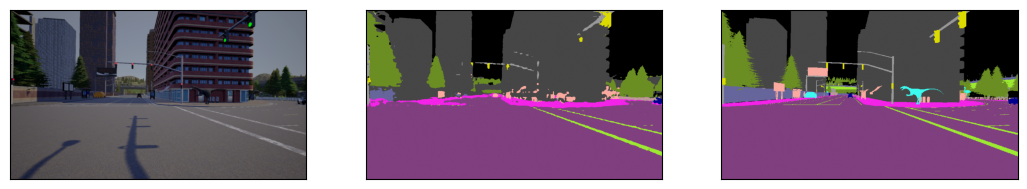

In [18]:
feature_extractor.eval()
with torch.no_grad():
    for batch in test_dl:
    
        imgs = batch['image'].to(device)
        labels = batch['labels'].to(device)
                    
        logits = feature_extractor(imgs)
        probability_vector = get_probability(logits,Prototype,device)
    
        fig, axs = plt.subplots(1, 3, figsize=(13, 13))
        idx = 3
        visualize_scene(imgs.cpu()[5], axs[0])
        visualize_annotation(torch.argmax(probability_vector,axis=3).cpu().detach().numpy()[5], axs[1])
        visualize_annotation(labels.cpu().detach().numpy()[5],axs[2])
        
        break
    
    

In [19]:
def MMSP(probability_map):
    MMSP_map = 1 - torch.max(probability_map, dim=3)[0] 
    return MMSP_map

In [20]:
def Probability_EDS(pixel_feature):
    pixel_features_reshaped = pixel_feature.permute(0, 2, 3, 1) 

    S_xy = torch.zeros(pixel_features_reshaped.shape[0], pixel_features_reshaped.shape[1], pixel_features_reshaped.shape[2], device=pixel_feature.device)
    
    for t in range(known_classes):
        prototypes_t = Prototype[t].to(device).view(1, 1, 1, -1)
        
        difference_numerator = pixel_features_reshaped - prototypes_t
        squared_diff_numerator = torch.sum(difference_numerator**2, dim=3)
        S_xy = S_xy + squared_diff_numerator

    MaxS = torch.max(S_xy) 
    P_EDS = 1 - S_xy / (MaxS + 1e-8) 
    
    return P_EDS

        
    

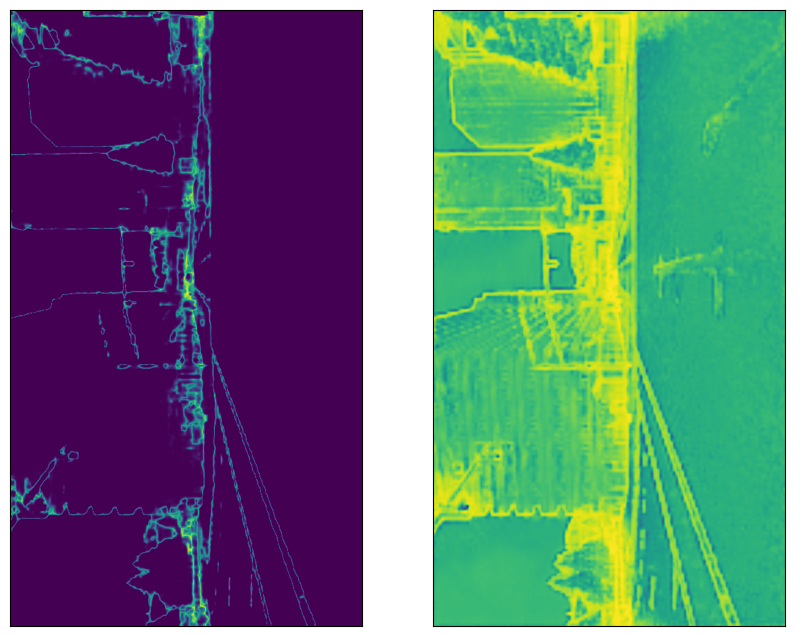

In [21]:
with torch.no_grad():
    for batch in test_dl:
    
        imgs = batch['image'].to(device)
        labels = batch['labels'].to(device)
                    
        logits = feature_extractor(imgs)
        probability_vector = get_probability(logits,Prototype,device)
    
        fig, axs = plt.subplots(1, 2, figsize=(10, 12))
        idx = 2
        
        visualize_scene(MMSP(probability_vector)[5].cpu().detach().numpy(), axs[0])
        visualize_scene(Probability_EDS(logits)[5].cpu().detach().numpy(), axs[1])
        
        break
    

In [22]:
def Anomaly_probability(MMSP_map, P_EDS_map, gamma, beta):

    alpha = 1 / (1 + torch.exp(-beta * (P_EDS_map - gamma)))

    Anomaly_p = alpha * P_EDS_map + (1 - alpha) * MMSP_map
    return Anomaly_p

def Final_map(logits, lambda_value, gamma, beta):

    probability_vector = get_probability(logits, Prototype, device) 
    vector_mmsp = MMSP(probability_vector) 
    vector_eds = Probability_EDS(logits) 
    Anomaly_map = Anomaly_probability(vector_mmsp, vector_eds, gamma, beta) # (B, H, W)
    segmentation_map = torch.argmax(probability_vector, dim=3) # (B, H, W)
    ood_label = 13 
    final_map = torch.where(Anomaly_map <= lambda_value, segmentation_map, torch.full_like(segmentation_map, ood_label))

    return final_map.cpu().numpy(), Anomaly_map.cpu().numpy()
    

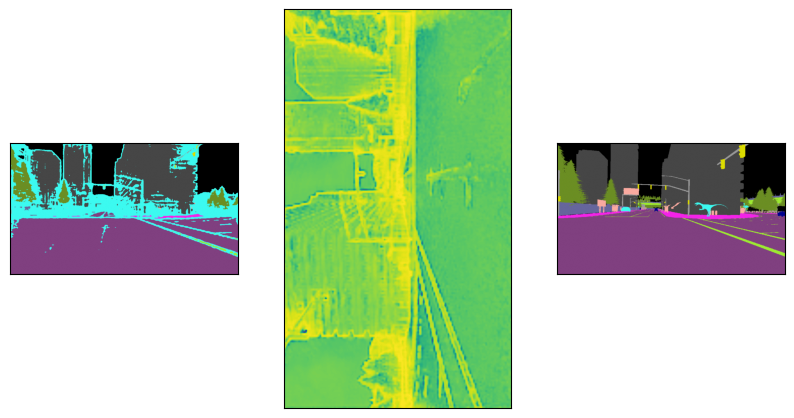

In [23]:
lambda_value = 0.7
with torch.no_grad():
    for batch in test_dl:
        
    
        imgs = batch['image'].to(device)
        labels = batch['labels'].to(device)
    
        fig, axs = plt.subplots(1, 3, figsize=(10, 12))
        idx = 2

        visualize_annotation(Final_map(logits,lambda_value,0.5,20)[0][5], axs[0])
        visualize_scene(Final_map(logits,lambda_value,0.5,20)[1][5], axs[1])
        visualize_annotation(labels.cpu().detach().numpy()[5],axs[2])
        
        break